In [1]:
!pip install ase==3.17 schnetpack==0.2.1

     |████████████████████████████████| 1.8MB 34.1MB/s eta 0:00:01
     |████████████████████████████████| 61kB 22.7MB/s eta 0:00:01
  Created wheel for schnetpack: filename=schnetpack-0.2.1-cp36-none-any.whl size=74862 sha256=7f8e069dbb67aa37872bd28fbc579adecfa34adf728a678a184d25c0233248f3
  Stored in directory: /root/.cache/pip/wheels/4e/28/d3/1748daf79d0a526f1a2de70e9a3abcdb50eb01b45eeec4b786
Successfully built schnetpack


In [2]:
!ls ../input

champs-scalar-coupling


In [3]:
import numpy as np
import pandas as pd
molecules = pd.read_csv('../input/champs-scalar-coupling/structures.csv')
molecules = molecules.groupby('molecule_name')
train = pd.read_csv('../input/champs-scalar-coupling/train.csv')
test = pd.read_csv('../input/qmkaggle/test.csv') # the original champs database mismatch with the submission file. We use the one from qmkaggle.
test['scalar_coupling_constant'] = -1

coupling_type = '1JHN' # change this input to convert different types of scc.

train = train[train.type == coupling_type]
test = test[test.type == coupling_type]

In [4]:
len(train)

43680

In [5]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
10,10,dsgdb9nsd_000002,1,0,1JHN,32.6889
13,13,dsgdb9nsd_000002,2,0,1JHN,32.6891
15,15,dsgdb9nsd_000002,3,0,1JHN,32.6905
99,99,dsgdb9nsd_000012,3,0,1JHN,55.5252
103,103,dsgdb9nsd_000012,4,0,1JHN,54.7359


In [6]:
len(test)

23895

In [7]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
61,4659137,dsgdb9nsd_000019,7,2,1JHN,-1
65,4659141,dsgdb9nsd_000019,8,2,1JHN,-1
611,4659687,dsgdb9nsd_000073,10,3,1JHN,-1
615,4659691,dsgdb9nsd_000073,11,3,1JHN,-1
732,4659808,dsgdb9nsd_000089,5,0,1JHN,-1


In [8]:
train_scalar_couplings = train.groupby('molecule_name')
test_scalar_couplings = test.groupby('molecule_name')

# ASE Database

In [9]:
from ase import Atoms
from ase.db import connect

def create_db(db_path, scalar_couplings, molecule_names):
    with connect(db_path) as db:
        for name in molecule_names:
            mol = molecules.get_group(name)
            atoms = Atoms(symbols=mol.atom.values,
                          positions=[(row.x,row.y,row.z) for row in mol.itertuples()])
            numbers = atoms.get_atomic_numbers()
            group = scalar_couplings.get_group(name)
            ai0 = group.atom_index_0.values
            ai1 = group.atom_index_1.values
            scc = group.scalar_coupling_constant.values
            ids = group.id.values
            for i, j, v, w in zip(ai0, ai1, scc, ids):
                new_numbers = numbers.copy()
                new_numbers[i] = 100 - new_numbers[i]
                new_numbers[j] = 100 - new_numbers[j]
                atoms.set_atomic_numbers(new_numbers)
                data = dict(scc=v)
                data[coupling_type+'_id'] = w
                db.write(atoms, name=name+'_H{}_C{}'.format(i,j), data=data)
                

In [10]:
properties=['scc', coupling_type+'_id']

In [11]:
import schnetpack

import sys
INT_MAX = sys.maxsize

dataset_size = INT_MAX

dataset_molecule_names = train.molecule_name.unique()
champs_path = 'CHAMPS_train.db' 
molecule_names = dataset_molecule_names[:dataset_size]
create_db(db_path=champs_path,
          scalar_couplings=train_scalar_couplings,
          molecule_names=molecule_names)
dataset = schnetpack.data.AtomsData(champs_path, properties=properties)

In [12]:
#dataset[30]

In [13]:
len(dataset)

43680

In [14]:
dataset_molecule_names = test.molecule_name.unique()
test_champs_path = 'CHAMPS_test.db' 
test_molecule_names = dataset_molecule_names[:dataset_size]
create_db(db_path=test_champs_path,
          scalar_couplings=test_scalar_couplings,
          molecule_names=test_molecule_names)
test_dataset = schnetpack.data.AtomsData(test_champs_path, properties=properties)

In [15]:
#test_dataset[0]

In [16]:
len(test_dataset)

23895

# SchNet Model

In [17]:
import pandas as pd

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack.datasets import *

device = torch.device("cuda")
#device = torch.device("cpu")
torch.manual_seed(12345)
np.random.seed(12345)

In [18]:
# The original function comes from the following script:
# https://github.com/atomistic-machine-learning/schnetpack/blob/v0.2.1/src/scripts/schnetpack_qm9.py
def evaluate_dataset(metrics, model, loader, device):
    # 为每一个 metric 重置其内部状态，准备计算新的指标
    for metric in metrics:
        metric.reset()

    # 在不更新模型参数的情况下，遍历数据集进行评估
    with torch.no_grad():
        for batch in loader:
            # 将数据移动到指定的设备上计算
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            # 使用当前模型计算结果
            result = model(batch)

            # 针对每一个 metric 计算其指标
            for metric in metrics:
                metric.add_batch(batch, result)

    # 返回每个 metric 的汇总结果
    results = [
        metric.aggregate() for metric in metrics
    ]
    return results

这个函数的目的是对给定数据集进行评估，计算一组指标。
参数metrics是一组衡量模型性能的指标类型，这些指标的实现被封装在预先定义好的Metric类中。
参数model是待评估的模型的实例。
参数loader是被评估数据集的DataLoader对象。
参数device指定了计算设备（CPU/GPU）。
这段函数首先重置每个指标的状态（例如计数器）。
接下来，使用带有torch.no_grad()上下文管理器的循环遍历数据集的每一个batch。
将batch数据移动到指定的设备上以进行计算。
使用当前模型计算结果并存储到变量result中。
对于每一个metric，调用其add_batch函数计算指标值。
最后构建一个结果列表，其中包含每个指标的汇总结果。
返回结果列表作为函数的输出

In [19]:
import torch.nn as nn
from schnetpack.data import Structure

class MolecularOutput(atm.OutputModule):
    def __init__(self, property_name, n_in=128, n_out=1, aggregation_mode='sum',
                 n_layers=2, n_neurons=None,
                 activation=schnetpack.nn.activations.shifted_softplus,
                 outnet=None):
        super(MolecularOutput, self).__init__(n_in, n_out)
        self.property_name = property_name
        self.n_layers = n_layers
        self.create_graph = False

        # 如果没有自定义输出网络，则使用默认的MLP作为输出组件
        if outnet is None:
            self.out_net = nn.Sequential(
                schnetpack.nn.base.GetItem('representation'),
                schnetpack.nn.blocks.MLP(n_in, n_out, n_neurons, n_layers, activation)
            )
        else:
            self.out_net = outnet

        # 根据聚合模式创建用于对分子属性进行汇总的组件
        if aggregation_mode == 'sum':
            self.atom_pool = schnetpack.nn.base.Aggregate(axis=1, mean=False)
        elif aggregation_mode == 'avg':
            self.atom_pool = schnetpack.nn.base.Aggregate(axis=1, mean=True)

    def forward(self, inputs):
        # 提取atom_mask以配合聚合操作
        atom_mask = inputs[Structure.atom_mask]

        # 使用输出网络对输入进行变换
        yi = self.out_net(inputs)

        # 使用atom_pool组件对原子特征进行聚合并生成最终结果
        y = self.atom_pool(yi, atom_mask)

        # 将结果以属性名称为键值的字典保存并返回
        result = {self.property_name: y}

        return result

MolecularOutput类是一个继承自atm.OutputModule的类，用于计算分子级属性（如能量、电荷等）。
property_name参数是需要计算的属性的名称。
n_in参数是输入向量中的特征向量维度。

n_out参数是输出的属性向量维度。
aggregation_mode参数是对原子向量进行汇总的聚合模式，可选值为sum和avg。
n_layers参数是输出网络中MLP层的个数。
n_neurons参数是输出网络中每层MLP的神经元个数，如果为None则使用默认值。
activation参数指定MLP中激活函数的类型，默认为shifted_softplus。
outnet参数允许传入自定义的输出网络。
在类的初始化函数中，首先调用atm.OutputModule的初始化函数来设置输入输出维度。
create_graph参数设置为 False，这表示该层不会在构建计算图的过程中保存节点信息。
根据指定的输出网络，初始化用于对原子特征向量进行聚合的组件。
在forward()函数中，提取出输入数据中的atom_mask，并使用输出网络对输入数据进行变换以计算出原子属性向量。
根据指定的聚合模式，使用atom_pool组件对原子属性向量进行汇总，得到最终结果。
将结果以属性名称为键值的字典形式保存并返回。

In [20]:
def schnet_model():
    # 在SchNet层中使用的原子向量的维数
    n_atom_basis = 128

    # SchNet层中使用的滤波器的数量
    n_filters = 128

    # SchNet层中的相互作用层数
    n_interactions = 6

    # 创建SchNet层
    reps = rep.SchNet(n_atom_basis, n_filters, n_interactions)

    # 创建MolecularOutput层
    output = MolecularOutput('scc')

    # 创建包含SchNet和MolecularOutput两个层的神经网络
    model = atm.AtomisticModel(reps, output)

    # 将神经网络移动到指定的设备上
    model = model.to(device)

    return model

schnet_model函数是创建SchNet模型的工厂函数，用于返回一个包含SchNet和MolecularOutput两个层的神经网络模型的实例。
在函数中首先定义了三个变量n_atom_basis、n_filters和n_interactions，分别表示了SchNet层中的原子向量维数、滤波器数量和相互作用层数。
使用这些参数，在rep模块中创建一个SchNet层，并将其存储在reps变量中。
使用属性为scc的MolecularOutput层作为网络的输出层，并且将其存储在output变量中。
使用reps和output两个层创建一个AtomisticModel对象，即包含SchNet和MolecularOutput两个层的神经网络。
将创建好的神经网络移动到指定的设备上进行计算。
返回搭建好的神经网络模型的实例

In [21]:
# Define a function to train the SchNet model
def train_model(max_epochs=500): 
    # print configuration
    print('max_epochs:', max_epochs)
    
    # split in train and val
n_dataset = len(dataset) # Get the size of the dataset
n_val = n_dataset // 10 # Split the dataset into Validation set and Training set
train_data, val_data, test_data = dataset.create_splits(n_dataset-n_val*2, n_val, 'split')
train_loader = spk.data.AtomsLoader(train_data, batch_size=128, num_workers=4, shuffle=True) # Create a data loader for the training data
val_loader = spk.data.AtomsLoader(val_data, batch_size=128, num_workers=4) # Create a data loader for the validation data

# create model
model = schnet_model()

# create trainer
output_key = "scc"
target_key = "scc"
opt = Adam(model.parameters(), lr=1e-3, weight_decay=1e-6) # Define the optimizer for the model
scheduler = MultiStepLR(opt, milestones=[15, 320], gamma=0.2) # Create learning rate scheduler
def loss(b, p): 
    return F.mse_loss(p[output_key], b[target_key]) # Define the loss function

# Define the metrics to measure the performance of the model
metrics = [
    spk.metrics.MeanAbsoluteError(target_key, output_key, name='MAE_scc'),
    spk.metrics.RootMeanSquaredError(target_key, output_key, name='RMSE_scc'),
]

# Define the hooks for the trainer, which run the training and validation in each epoch
# Define several useful hooks, including CSV hook to save the training and validation metrics to a CSV file,
# LRSchedule hook to adjust the learning rate using scheduler, and MaxEpochHook to stop the training when it reaches the maximum number of epochs. 
hooks = [
    spk.train.MaxEpochHook(max_epochs),
    spk.train.CSVHook('log', metrics, every_n_epochs=1),
    spk.train.LRScheduleHook(scheduler),
]

trainer = spk.train.Trainer('output', model, loss, opt, train_loader, val_loader, hooks=hooks) # Create the trainer object

# start training
trainer.train(device) # Start training the model

# evaluation
model.load_state_dict(torch.load('output/best_model')) # Load the best model
test_loader = spk.data.AtomsLoader(test_data, batch_size=128, num_workers=4) # Create a data loader for the testing data
model.eval() # Set the model to evaluation mode

# evaluate the model and print the metrics
df = pd.DataFrame() # Define a dataframe to hold the metrics
df['metric'] = [
    'MAE_scc', 'RMSE_scc',
]
df['training'] = evaluate_dataset(metrics, model, train_loader, device) # Evaluate on training data
df['validation'] = evaluate_dataset(metrics, model, val_loader, device) # Evaluate on validation data
df['test'] = evaluate_dataset(metrics, model, test_loader, device) # Evaluate on testing data
df.to_csv('output/evaluation.csv', index=False) # Save the metrics to a CSV file
display(df) # Print the metrics

return test_data

train_model函数是对SchNet模型进行训练和评估的主函数，它输出测试集的信息。
max_epochs参数指定了训练的最大迭代次数。
使用create_splits()函数将原始数据集按照比例分为训练集、验证集和测试集，并分别创建相应的AtomsLoader对象。
调用schnet_model()函数创建SchNet模型。
定义模型优化器、学习率调度器、损失函数和评估指标等组件，并将它们用于创建一个训练器（spk.train.Trainer）。
使用trainer进行模型训练，并最终得到在测试集上的性能指标（即通过evaluate_dataset计算得到的指标值）。
对模型进行评估：首先加载在验证集上表现最好的模型，并在测试集上对该模型进行测试。
使用在测试集上表现最好的模型对训练集、验证集和测试集进行评估，分别计算指标并将其保存在DataFrame中。
将评估结果保存到output/evaluation.csv文件中。
在输出中展示评估指标，并返回测试集数据

In [22]:
def show_history():
    df = pd.read_csv('log/log.csv')
    # Load the training and validation metrics from the CSV file
    display(df.tail())
    # Show the last five rows of the loaded data
    
    _ = display(df[['MAE_scc', 'RMSE_scc']].plot())
    # Plot the MAE and RMSE histories over epochs

In [23]:
# Define a function for testing the SchNet model performance on a given dataset
def test_prediction(dataset):
    # create model
    model = schnet_model()
    
    # load best parameters
    model.load_state_dict(torch.load('output/best_model'))
    loader = spk.data.AtomsLoader(dataset, batch_size=128, num_workers=4)
    model.eval()# Set the model to evaluation mode
    
    # predict scalar coupling constants
    entry_id = []
    predictions = []
    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)# Get the predicted scalar couping constant for the batch

            # Append the scalar couping constant predictions to the list along with their associated ID
            entry_id += batch[coupling_type+'_id'].long().view(-1).tolist()
            predictions += result['scc'].view(-1).tolist()
    # Return the IDs and their associated scalar couping constant predictions
    return entry_id, predictions

这个函数是用于测试SchNet模型在给定数据集上的性能表现的。

函数的输入参数为一个数据集对象dataset。该数据集在上面的训练和验证过程中已经定义好了，它包含了分子结构和目标标签信息等内容。

在函数内部，首先我们调用schnet_model函数创建一个新的模型。接着，我们使用load_state_dict函数从已经训练好的best_model的参数数据中恢复到我们所创建的新模型中。

我们然后通过AtomsLoader函数创建一个数据加载器，以便于对数据集中的数据进行批量处理。我们在模型上调用eval函数，以便于模型主要运行在inference模式下。

我们使用no_grad函数来避免在推理过程中计算梯度，这样可以节省内存。我们用一个循环来遍历数据加载器中的batch，并使用model进行前向计算。在每个batch上，我们将得到的预测值放入一个对应的列表中。最后，函数返回的是一个元组，包含了分子ID列表和对应的预测标签的列表，元素总数等于数据集中的分子数量。

In [24]:
def show_predictions(dataset, train_df):# Test the model's performance on the given dataset
    scc_id, scc = test_prediction(dataset)
    df_pred = pd.DataFrame()
    df_pred['Prediction'] = scc
    df_pred['id'] = scc_id
    df_pred = train_df.merge(df_pred, on='id', how='inner')# Merge the training data and prediction into the same dataframe
    # Print the first five entries of the merged dataframe
    display(df_pred.head())
    # Plot the predicted vs target scalar couping constants in a scatter plot
    df_pred['Target'] = df_pred['scalar_coupling_constant']
    display(df_pred.plot.scatter(x='Target', y='Prediction', title=coupling_type, figsize=(5,5)))
    # Save the predicted scalar couping constants to a CSV file
    df_pred[['id', 'Target', 'Prediction']].to_csv('test_predictoins_{}.csv'.format(coupling_type), index=False)
    # Calculate the RMSE and MAE performance metrics
    diff = (df_pred['Prediction'].values-df_pred['Target'].values)
    rmse = np.sqrt(np.mean(diff**2))
    mae = np.mean(np.abs(diff))
    # Print the performance metrics in a table
    df_eval = pd.DataFrame()
    df_eval['RMSE'] = [rmse]
    df_eval['MAE'] = [mae]
    df_eval['log(MAE)'] = [np.log(mae)]
    _ = display(df_eval)

show_predictions函数的输入参数有两个，一个是测试集dataset，一个是训练集train_df。

首先，我们调用test_prediction函数，用SchNet模型在测试集上预测标签。然后，我们将预测的标签和分子ID建立为一个新的DataFrame，并将其与训练数据集进行合并，生成一个包含测试集分子的预测和训练集中已知的标签的DataFrame。

接着，我们绘制预测值与目标值的散点图，其中X轴是目标值，Y轴是预测值，这可以用来展示模型预测的好坏程度。我们还将预测结果保存到csv文件中以备后续分析使用。

最后，我们计算一些性能指标，例如RMSE（均方根误差）和MAE（平均绝对误差），并将它们打印为打印成一个表格。

# Results

In [25]:
import warnings
warnings.filterwarnings('ignore')
# [Solved] FutureWarning: Passing (type, 1) or ‘1type’ as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / ‘(1,)type’
# import warnings and ignore all the warnings below.
used_test_data = train_model(max_epochs=5)
warnings.filterwarnings('default')

max_epochs: 1


,metric,training,validation,test
0,MAE_scc,1.608627,1.615924,1.625921
1,RMSE_scc,2.136503,2.099473,2.138610


,Time,Learning rate,Train loss,Validation loss,MAE_scc,RMSE_scc
0,46.828511,0.001,12920.522716,4.407789,1.615924,2.099473


/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


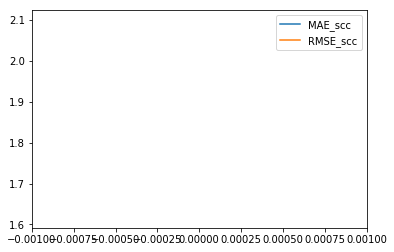

In [26]:
show_history()

In [27]:
split = np.load('split.npz')

In [28]:
list(split.keys())

['train_idx', 'val_idx', 'test_idx']

In [29]:
used_test_data =  dataset.create_subset(split['test_idx'])

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,Prediction
0,103,dsgdb9nsd_000012,4,0,1JHN,54.7359,47.757782
1,231,dsgdb9nsd_000020,6,2,1JHN,47.3937,47.402878
2,997,dsgdb9nsd_000065,10,2,1JHN,38.0507,37.591972
3,3739,dsgdb9nsd_000201,10,3,1JHN,59.1131,59.502327
4,4446,dsgdb9nsd_000237,7,0,1JHN,55.7552,52.667114


,RMSE,MAE,log(MAE)
0,2.13861,1.625921,0.486074


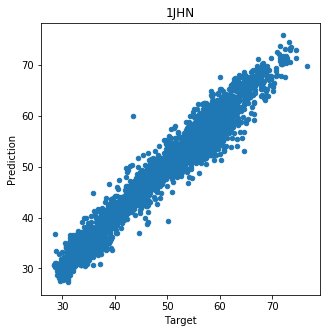

In [30]:
show_predictions(used_test_data, train)

In [31]:
def make_submission():
    scc_id, scc = test_prediction(test_dataset)
    submission = pd.DataFrame()
    submission['id'] = scc_id
    submission['scalar_coupling_constant'] = scc
    submission.to_csv('submission_{}.csv'.format(coupling_type), index=False)

In [32]:
make_submission()

KeyboardInterrupt: 